## 선형 판별 분석을 통한 지도 방식의 데이터 압축

선별 판별 분석(LDA)은 규제가 없는 모델에서 특성 추출 기법을 사용한다.<br/>
LDA는 클래스 레이블을 사용하는 지도 학습 알고리즘이다.<br/>
LDA의 목표는 클래스를 최적으로 구분할 수 있는 특성 부분 공간을 찾는 것이다.<br/>
LDA는 클래스간의 거리는 최대화, 각 클래스 내의 분산은 최소가 되게 한다.<br/>

LDA 알고리즘은 다음과 같다.

1. $d$차원의 데이터셋을 표준화한다.($d$는 특성의 개수)
2. 각 클래스에 대해 $d$차원의 평균 벡터를 계산한다.
3. 클래스 간의 산포행렬 $S_B$과 클래스 내의 산포행렬 $S_W$를 구성한다.
4. $S_W^{-1}S_B$ 행렬의 고유벡터와 고윳값을 계산한다.
5. 고윳값을 내림차순으로 정렬한다.
6. 고윳값이 가장 큰 $k$개의 고유벡터를 선택해서 변환행렬 $W$를 구성한다.
7. 변환행렬 $W$를 사용해서 샘플을 새로운 특성 부분 공간으로 투영한다.

In [1]:
# Wine 데이터셋 로그 

import pandas as pd

df_wine = pd.read_csv('https://archive.ics.uci.edu'
                      '/ml/machine-learning-databases/wine/wine.data', header=None)

In [2]:
# Wine 데이터셋을 7:3 비율로 훈련셋과 테스트셋으로 나눈다.

from sklearn.model_selection import train_test_split

# 인덱스 1에서 인덱스 13까지 특성을 넘파일 배열로 변환하여 x에 할당
x = df_wine.iloc[:, 1:].values
# 첫번째 열의 클래스 레이블을 y에 할당
y = df_wine.iloc[:, 0].values
# train_test_split 함수를 사용하여 x와 y를 랜덤하게 훈련셋과 테스트셋으로 분할
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.3,      # 와인 샘플의 30%가 x_test와 y_test에 할당 
    random_state=0, 
    stratify=y          # y로 하면 훈련셋과 테스트셋에 있는 클래스 비율이 원본 데이터셋과 동일하게 유지됨
)

In [3]:
# 특성을 표준화 한다.

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train_std = sc.fit_transform(x_train)
x_test_std = sc.fit_transform(x_test)

### 산포행렬 만들기

클래스 간 산포행렬과 클래스 내 산포행렬을 만들기 위해서는 평균벡터가 필요하다.<br/>
평균벡터를 만드는 공식은 다음과 같다.

$$m_i={1 \over n_i}\sum_{x \in D_i}^cx_m$$

평균벡터는 다음과 같이 구현할 수 있다.

In [20]:
import numpy as np

# 평균벡터를 만든다.
np.set_printoptions(precision=4)
mean_vecs=[]
for label in range(1, 4):
    mean_vecs.append(np.mean(x_train_std[y_train == label], axis=0))
    print('MV %s: %s \n' %(label, mean_vecs[label-1]))

MV 1: [ 0.9066 -0.3497  0.3201 -0.7189  0.5056  0.8807  0.9589 -0.5516  0.5416
  0.2338  0.5897  0.6563  1.2075] 

MV 2: [-0.8749 -0.2848 -0.3735  0.3157 -0.3848 -0.0433  0.0635 -0.0946  0.0703
 -0.8286  0.3144  0.3608 -0.7253] 

MV 3: [ 0.1992  0.866   0.1682  0.4148 -0.0451 -1.0286 -1.2876  0.8287 -0.7795
  0.9649 -1.209  -1.3622 -0.4013] 



평균벡터 $m_i$를 사용해서 클래스 내 산포행렬을 만드는 공식은 다음과 같다.

$$S_i=\sum_{x \in D_i}^c(x-m_i)(x-mi)^T$$ 

$$S_W=\sum_{i=1}^cS_i$$ 

클래스 내 산포행렬은 다음과 같이 구현할 수 있다.

In [21]:
d = 13  # Wine 데이터셋 특성 개수
scatter_matrix_w = np.zeros((d, d))
for label, mv in zip(range(1, 4), mean_vecs):
    # 개발 산포행렬 Si를 산포행렬 Sw로 모두 더하기 전에 스케일을 조정해야 하는데 이것은 공분산 행렬을 계산(np.cov)하는 것과 같다.
    class_scatter = np.cov(x_train_std[y_train == label].T, bias=True)
    scatter_matrix_w += class_scatter

print('클래스 내의 산포 행렬: %sx%s' % (scatter_matrix_w.shape[0], scatter_matrix_w.shape[1]))

클래스 내의 산포 행렬: 13x13


클래스 간의 산포행렬을 구하는 공식은 다음과 같다. 

$$S_B=\sum_{i=1}^cn_i(m_i-m)(m_i-m)^T$$

여기서 $m$은 모든 클래스의 샘플을 포함하여 계산된 전체 평균이다.

클래스 간의 산포행렬를 구현하면 다음과 같다. 

In [23]:
# 샘플 전체 평균 구하기
mean_overall = np.mean(x_train_std, axis=0) 
mean_overall = mean_overall.reshape(d, 1)   # 열 벡터로 만들기
d = 13  # Wine 데이터셋 특성 개수
scatter_matrix_b = np.zeros((d, d))
for i, mean_vec in enumerate(mean_vecs):
    n = x_train[y_train == i + 1, :].shape[0]
    mean_vec = mean_vec.reshape(d, 1)   # 열 벡터로 만들기
    scatter_matrix_b += n * (mean_vec - mean_overall).dot((mean_vec - mean_overall).T)

print('클래스 간의 산포 행렬: %sx%s' % (scatter_matrix_b.shape[0], scatter_matrix_b.shape[1]))

클래스 간의 산포 행렬: 13x13


$S_W^{-1}S_B$ 행렬의 고유벡터와 고윳값을 계산

In [24]:
eigen_vals, eigen_vecs = np.linalg.eig(np.linalg.inv(scatter_matrix_w).dot(scatter_matrix_b))
# 내림차순으로 고윳값을 정렬한다.

eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:,i]) for i in range(len(eigen_vals))]
eigen_pairs = sorted(eigen_pairs, key=lambda k: k[0], reverse=True)
print('내림차순의 고윳값:\n')
for eigen_val in eigen_pairs:
    print(eigen_val[0])

내림차순의 고윳값:

358.0042070133659
177.07768640666225
2.842170943040401e-14
2.2513016031041443e-14
1.800270811737676e-14
1.800270811737676e-14
1.578515719598725e-14
1.3662940131811948e-14
1.3662940131811948e-14
9.798790178197109e-15
9.798790178197109e-15
2.90135780637586e-15
9.905045812450375e-16


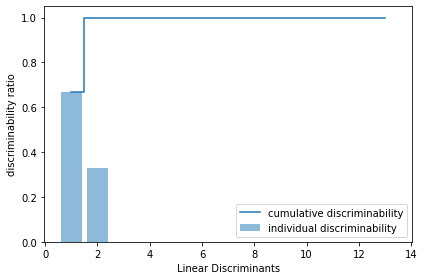

In [25]:
# 고윳값의 설명된 분산 비율을 그래프로 그려보기

# 전체 고윳값의 합
tot = sum(eigen_vals.real)
# 전체 고윳값의 합에서 고윳값의 비율을 구한다.
discr = [(i / tot) for i in sorted(eigen_vals.real, reverse=True)]
# np.cumsum 함수는 누적 합을 계산한다.
cum_discr = np.cumsum(discr)

import matplotlib.pyplot as plt

plt.bar(range(1,14), discr, alpha=0.5, align='center', label='individual discriminability')
plt.step(range(1,14), cum_discr, where='mid', label='cumulative discriminability')
plt.ylabel('discriminability ratio')
plt.xlabel('Linear Discriminants')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [26]:
# 두개의 판별 고유 벡터를 열로 쌓아서 변환 행렬 W를 만들면 다음과 같다. 

w = np.hstack((
    eigen_pairs[0][1][:, np.newaxis].real, 
    eigen_pairs[1][1][:, np.newaxis].real
))

print('행렬 W:\n', w)

행렬 W:
 [[-0.1484 -0.4093]
 [ 0.091  -0.1583]
 [-0.0168 -0.3536]
 [ 0.1487  0.322 ]
 [-0.0165 -0.0813]
 [ 0.1912  0.0841]
 [-0.7333  0.2828]
 [-0.0751 -0.0099]
 [ 0.002   0.0902]
 [ 0.2953 -0.2168]
 [-0.0327  0.274 ]
 [-0.3539 -0.0133]
 [-0.3918 -0.5954]]


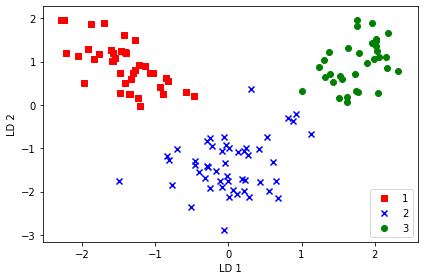

In [27]:
# 변환 행렬 W를 훈련셋에 곱해서 데이터를 변환한다.
x_train_lda = x_train_std.dot(w)

# 산점도를 그린다. 

colors = ['r', 'b', 'g']
markers = ['s', 'x', 'o']

for l, c, m in zip(np.unique(y_train), colors, markers):
    plt.scatter(
        x_train_lda[y_train == l, 0],
        x_train_lda[y_train == l, 1] * (-1),
        c=c, label=l, marker=m
    )
    
plt.xlabel('LD 1')
plt.ylabel('LD 2')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
